In [1]:
# 06_custom_rankings_by_metric.ipynb
# 🏆 Build Custom Rankings by Any Team Stat

# 🛠 Requirements:
# - pandas, matplotlib, seaborn (install via `pip install pandas matplotlib seaborn`)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

DATA_DIR = "./data"

plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [15,8]

In [2]:
# 📂 Load 2023 season advanced stats
stats_path = os.path.join(DATA_DIR, "advanced_season_stats", "2023.csv")
stats = pd.read_csv(stats_path)

# Filter to FBS teams only
teams = stats[stats["conference"].notnull()].copy()

print(f"{len(teams)} FBS teams loaded")
teams.head()

134 FBS teams loaded


,season,team,conference,offense_passingPlays_explosiveness,offense_passingPlays_successRate,offense_passingPlays_totalPPA,offense_passingPlays_ppa,offense_passingPlays_rate,offense_rushingPlays_explosiveness,offense_rushingPlays_successRate,...,defense_lineYardsTotal,defense_lineYards,defense_stuffRate,defense_powerSuccess,defense_explosiveness,defense_successRate,defense_totalPPA,defense_ppa,defense_drives,defense_plays
0,2023,Air Force,Mountain West,2.308738,0.409091,54.829427,0.498449,0.134639,0.971259,0.469417,...,964,2.722316,0.180791,0.780000,1.176033,0.402204,86.218708,0.118759,137,726
1,2023,Akron,Mid-American,1.328119,0.357143,29.299802,0.067511,0.591281,0.869081,0.405594,...,1225,3.010319,0.159705,0.727273,1.340526,0.397878,101.048131,0.134016,139,754
2,2023,Alabama,SEC,1.860456,0.430518,142.236419,0.387565,0.416572,0.996721,0.462745,...,1276,2.946420,0.152425,0.666667,1.328617,0.350797,102.080285,0.116265,169,878
3,2023,App State,Sun Belt,1.595906,0.494647,206.380380,0.441928,0.474112,0.972274,0.424658,...,1519,3.330263,0.155702,0.780488,1.263683,0.424642,157.148979,0.172881,168,909
4,2023,Arizona,Big 12,1.588850,0.504202,224.401777,0.471432,0.557377,0.878248,0.509434,...,1174,3.025773,0.198454,0.693878,1.226676,0.411415,104.368164,0.124100,149,841


In [3]:
# 🔍 Show all available numeric columns for selection

numeric_cols = teams.select_dtypes(include=["float64", "int64"]).columns.tolist()
excluded = ['season', 'year', 'games', 'plays']  # remove less useful fields
metric_options = [col for col in numeric_cols if col not in excluded]

print("Available metrics:")
for col in metric_options:
    print(f" - {col}")

Available metrics:
 - offense_passingPlays_explosiveness
 - offense_passingPlays_successRate
 - offense_passingPlays_totalPPA
 - offense_passingPlays_ppa
 - offense_passingPlays_rate
 - offense_rushingPlays_explosiveness
 - offense_rushingPlays_successRate
 - offense_rushingPlays_totalPPA
 - offense_rushingPlays_ppa
 - offense_rushingPlays_rate
 - offense_passingDowns_explosiveness
 - offense_passingDowns_successRate
 - offense_passingDowns_ppa
 - offense_passingDowns_rate
 - offense_standardDowns_explosiveness
 - offense_standardDowns_successRate
 - offense_standardDowns_ppa
 - offense_standardDowns_rate
 - offense_havoc_db
 - offense_havoc_frontSeven
 - offense_havoc_total
 - offense_fieldPosition_averagePredictedPoints
 - offense_fieldPosition_averageStart
 - offense_pointsPerOpportunity
 - offense_totalOpportunies
 - offense_openFieldYardsTotal
 - offense_openFieldYards
 - offense_secondLevelYardsTotal
 - offense_secondLevelYards
 - offense_lineYardsTotal
 - offense_lineYards
 - of

In [4]:
# 🧠 Define your metrics and weights here
# Format: ("metric_name", weight, higher_is_better)

ranking_config = [
    ("offense_ppa", 0.3, True),
    ("offense_successRate", 0.15, True),
    ("offense_explosiveness", 0.05, True),
    ("defense_ppa", 0.3, False),
    ("defense_successRate", 0.15, False),
    ("defense_explosiveness", 0.05, False)
]

# Sanity check: weights should sum to 1.0
assert abs(sum(w for _, w, _ in ranking_config) - 1.0) < 1e-6

In [5]:
# 📊 Normalize each metric and apply weight

ranked = teams[["team", "conference"]].copy()

for metric, weight, higher_is_better in ranking_config:
    # Normalize using min-max scaling
    col = teams[metric]
    if higher_is_better:
        norm = (col - col.min()) / (col.max() - col.min())
    else:
        norm = (col.max() - col) / (col.max() - col.min())
    
    ranked[metric + "_norm"] = norm
    ranked[metric + "_contrib"] = norm * weight


In [6]:
# 🏁 Final score and ranking

contrib_cols = [col for col in ranked.columns if col.endswith("_contrib")]
ranked["composite_score"] = ranked[contrib_cols].sum(axis=1)
ranked["rank"] = ranked["composite_score"].rank(ascending=False, method="min")
ranked = ranked.sort_values("rank").reset_index(drop=True)

# Show top 15
cols_to_show = ["team", "conference", "composite_score", "rank"] + contrib_cols
ranked[cols_to_show].head(15)


,team,conference,composite_score,rank,offense_ppa_contrib,offense_successRate_contrib,offense_explosiveness_contrib,defense_ppa_contrib,defense_successRate_contrib,defense_explosiveness_contrib
0,Oregon,Big Ten,0.831175,1.0,0.292105,0.150000,0.022575,0.231282,0.105032,0.030181
1,Notre Dame,FBS Independents,0.814386,2.0,0.222808,0.107337,0.026727,0.292956,0.137373,0.027186
2,Michigan,Big Ten,0.772709,3.0,0.194363,0.093323,0.016922,0.295771,0.137232,0.035099
3,Georgia,SEC,0.763842,4.0,0.253996,0.126131,0.020580,0.223140,0.111161,0.028834
4,Ohio State,Big Ten,0.746035,5.0,0.196126,0.084159,0.019874,0.282964,0.124087,0.038825
5,Penn State,Big Ten,0.740851,6.0,0.170825,0.088627,0.007716,0.300000,0.150000,0.023683
6,SMU,ACC,0.727755,7.0,0.185734,0.074680,0.028905,0.279561,0.135009,0.023864
7,Oklahoma,SEC,0.684499,8.0,0.213882,0.105971,0.025806,0.217303,0.107531,0.014005
8,Troy,Sun Belt,0.651554,9.0,0.149877,0.054920,0.031218,0.276670,0.107585,0.031285
9,James Madison,Sun Belt,0.651396,10.0,0.160754,0.086421,0.018108,0.234235,0.142927,0.008952


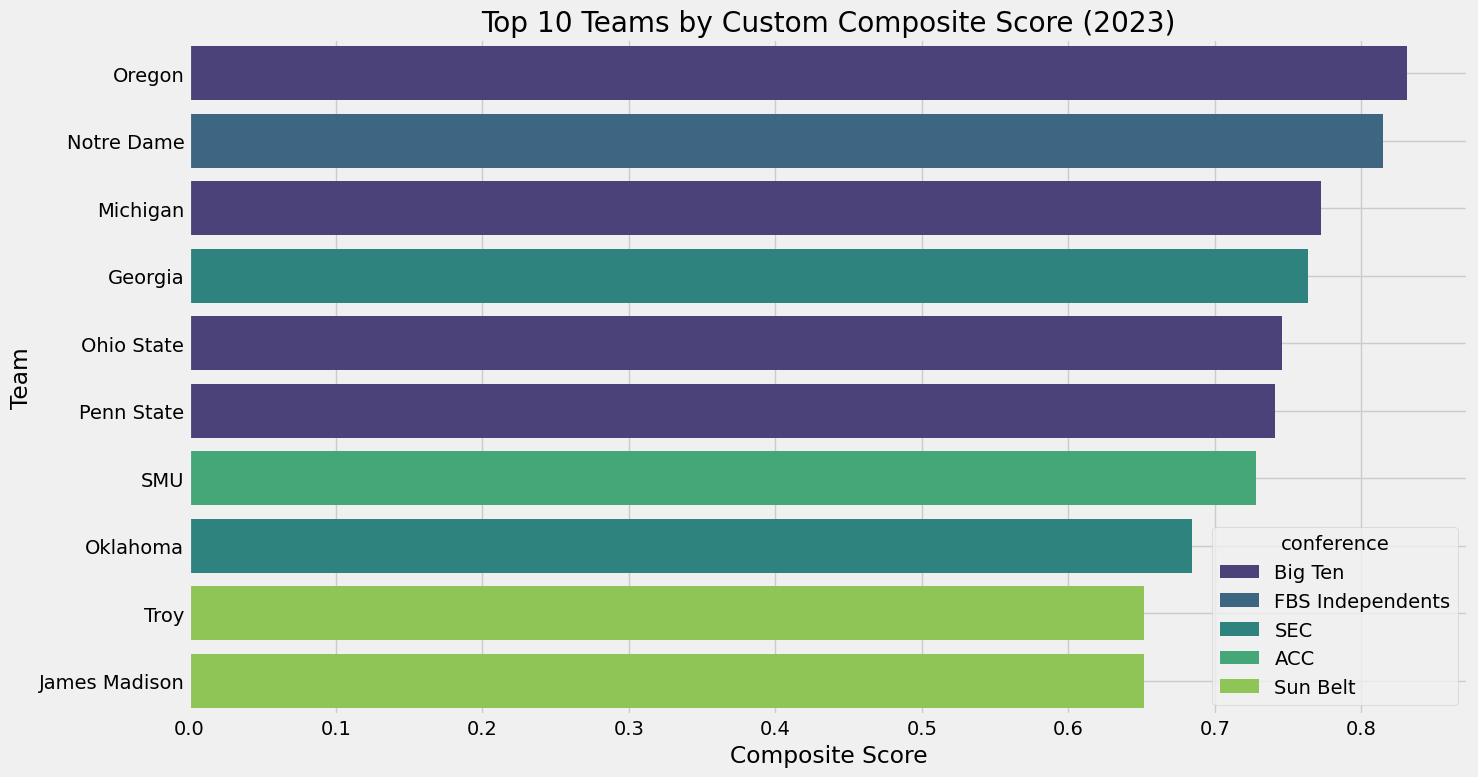

In [7]:
# 📊 Visualize top 10 teams by composite score

sns.barplot(
    data=ranked.head(10),
    x="composite_score",
    y="team",
    hue="conference",
    dodge=False,
    palette="viridis"
)
plt.title("Top 10 Teams by Custom Composite Score (2023)")
plt.xlabel("Composite Score")
plt.ylabel("Team")
plt.grid(True)
plt.tight_layout()
plt.show()


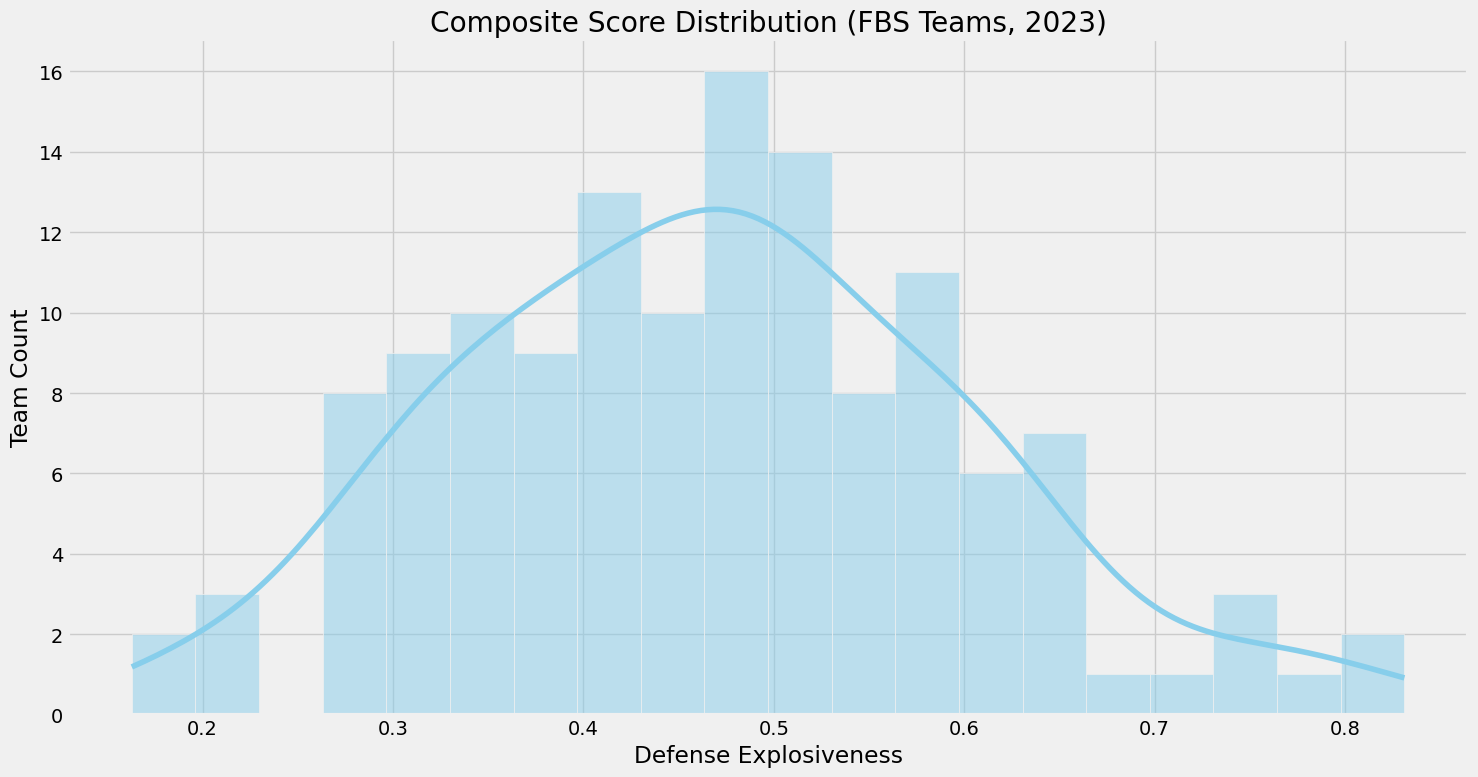

In [8]:
# 📈 Optional: Histogram of metric distribution

sns.histplot(
    data=ranked,
    x='composite_score',
    bins=20,
    kde=True,
    color="skyblue"
)
plt.title(f"Composite Score Distribution (FBS Teams, 2023)")
plt.xlabel(metric.replace("_", " ").title())
plt.ylabel("Team Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# ✅ Summary

# You've just:
# - Defined a custom metric-weighted formula
# - Normalized and combined metrics
# - Ranked and visualized the top teams

# 🧪 Try This:
# - Swap in defensive stats or tempo
# - Create separate offense/defense rankings
# - Compare to your own intuition or betting spreads
